In [1]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import rcParams


In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'

adata = sc.read_h5ad(path + 'final/stored/merged_citeseq_040224_6.h5ad')
adata

AnnData object with n_obs × n_vars = 274255 × 36738
    obs: 'Age', 'Gender', 'Condition', 'Admission', 'ID', 'Sample', 'Stage', 'Experiment', 'Dengue_exposure', 'Date', 'Date of symptoms onset', 'Days', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'mad_prd', 'n_proteins_by_counts', 'total_counts_adt', 'rna_quality', 'protein_quality', 'high_quality', 'TCR_umi', 'TCR_IR_VJ_2_c_call', 'TCR_IR_VDJ_2_c_call', 'TCR_IR_VJ_2_d_call', 'TCR_IR_VDJ_2_d_call', 'TCR_IR_VJ_2_v_call', 'TCR_IR_VDJ_2_v_call', 'TCR_IR_VJ_1_c_call', 'TCR_IR_VDJ_1_c_call', 'TCR_IR_VJ_1_d_call', 'TCR_IR_VDJ_1_d_call', 'TCR_IR_VJ_1_v_call', 'TCR_IR_VDJ_1_v_call', 'TCR_has_ir', 'TCR_receptor_subtype', 'TCR_chain_pairing', 'BCR_umi', 'BCR_IR_VJ_2_c_call', 'BCR_IR_VDJ_2_c_call', 'BCR_IR_VJ_2_d_call', 'BCR_IR_VDJ_2_d_call', 'BCR_IR_VJ_2_v_call', 'BCR_IR_VDJ_2_v_call', 'BCR_IR_VJ_1_c_call', 'BCR_IR_VDJ_1_c_call', 'BCR_IR_VJ_1_d_call', 'BCR_IR_VDJ_1_d_call', 'BC

In [6]:
filtered = adata[(adata.obs.total_counts >= 1000) &
                  #(adata.obs.total_counts <= 30000) &
                  (adata.obs.n_genes_by_counts >= 400) &
                  (adata.obs.pct_counts_mt < 15) &
                  #(adata.obs.total_counts_adt <= 10000) &
                  #(adata.obs.predicted_doublets == False) &
                  (adata.obs.mad_prd == False) &
                 (~adata.obs.ID.isin(['1_052_02', '1_052_01', '1_057_02', '1_057_01',])) &
                (~adata.obs.Condition.isin(['co', 'DWS']))
                 ].copy()
filtered = filtered[:, [x for x in filtered.var_names if not x.startswith('Isotype')]]
sc.pp.filter_genes(filtered, min_cells=3)
filtered.X = filtered.layers['dsb'].copy()
filtered

AnnData object with n_obs × n_vars = 178527 × 29396
    obs: 'Age', 'Gender', 'Condition', 'Admission', 'ID', 'Sample', 'Stage', 'Experiment', 'Dengue_exposure', 'Date', 'Date of symptoms onset', 'Days', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublets', 'mad_prd', 'n_proteins_by_counts', 'total_counts_adt', 'rna_quality', 'protein_quality', 'high_quality', 'TCR_umi', 'TCR_IR_VJ_2_c_call', 'TCR_IR_VDJ_2_c_call', 'TCR_IR_VJ_2_d_call', 'TCR_IR_VDJ_2_d_call', 'TCR_IR_VJ_2_v_call', 'TCR_IR_VDJ_2_v_call', 'TCR_IR_VJ_1_c_call', 'TCR_IR_VDJ_1_c_call', 'TCR_IR_VJ_1_d_call', 'TCR_IR_VDJ_1_d_call', 'TCR_IR_VJ_1_v_call', 'TCR_IR_VDJ_1_v_call', 'TCR_has_ir', 'TCR_receptor_subtype', 'TCR_chain_pairing', 'BCR_umi', 'BCR_IR_VJ_2_c_call', 'BCR_IR_VDJ_2_c_call', 'BCR_IR_VJ_2_d_call', 'BCR_IR_VDJ_2_d_call', 'BCR_IR_VJ_2_v_call', 'BCR_IR_VDJ_2_v_call', 'BCR_IR_VJ_1_c_call', 'BCR_IR_VDJ_1_c_call', 'BCR_IR_VJ_1_d_call', 'BCR_IR_VDJ_1_d_call', 'BC

In [4]:
filtered.obs.rna_ct_2_2.cat.categories

Index(['B cells', 'Doublets', 'HSPCs', 'Monocytes', 'Plasmablasts',
       'Platelets', 'cDCs', 'pDCs', 'T cells', 'NK cells', 'Erythroblasts'],
      dtype='object')

In [5]:
filtered.obs.rna_ct_2_2.cat.reorder_categories(['NK cells', 'Monocytes', 'cDCs', 'pDCs', 'T cells', 'B cells', 'Plasmablasts', 'Platelets', 'HSPCs', 'Erythroblasts', 'Doublets', ], inplace=True)

In [9]:
filtered.obs.Condition.cat.categories

Index(['D', 'SD'], dtype='object')

In [10]:
acute = filtered[filtered.obs.Stage == 'acute'].copy()
convalescence = filtered[filtered.obs.Stage == 'convalescence'].copy()

In [11]:
cell_types = ['NK cells', 'Monocytes', 'cDCs',]

In [12]:
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

SD_IDs = acute[acute.obs['Condition'] == 'SD'].obs['ID'].cat.categories
D_IDs = acute[acute.obs['Condition'] == 'D'].obs['ID'].cat.categories

t_res_dic = pd.DataFrame([])
for ct in cell_types:
    t_res = pd.DataFrame([], index=acute.var_names)
    t_res['cell_type'] = ct
    
    adata_ct = acute[acute.obs['rna_ct_2_2'] == ct]
    t_res['log2fc'] = pd.DataFrame((adata_ct[adata_ct.obs['Condition'] == 'SD'].X.mean(axis=0) - adata_ct[adata_ct.obs['Condition'] == 'D'].X.mean(axis=0)), columns=adata_ct.var_names).T

    gs_SD = []
    for i, ID in enumerate(SD_IDs):
        SDi = adata_ct[adata_ct.obs['ID'] == ID]
        if SDi.obs.shape[0] < 5: 
            print(f'SD patient {ID} have only {SDi.obs.shape[0]} {ct}. Skipping!')
            continue
        gs_SD.append(np.asarray(SDi.X.mean(axis=0))[0])

#     gs_D = np.empty((len(D_IDs), adata_ct.var_names.shape[0]))
    gs_D = []
    for i, ID in enumerate(D_IDs):
        Di = adata_ct[adata_ct.obs['ID'] == ID]
        if Di.obs.shape[0] < 5:
            print(f'D patient {ID} have only {Di.obs.shape[0]} {ct}. Skipping!')
            continue
        gs_D.append(np.asarray(Di.X.mean(axis=0))[0])     
    
    # t-test
    t, p = mannwhitneyu(gs_SD, gs_D, axis=0)
    resi = pd.Series(t, index=adata_ct.var_names, name='statistic').to_frame()
    resi['pvalue_wilcoxon'] = p
    #resi['cell_type'] = ct
    t_res = pd.concat([t_res, resi], axis=1, join='outer')
    
    # t-test
    ks_res = pd.DataFrame([], columns = ['pvalue_ks', 'stats_ks', 'log2fc_patient_average_med', 'log2fc_patient_average_mean'], index=t_res.index)
    for gene in t_res.index:
        st,pval = ks_2samp(gs_SD[0], gs_D[0])
        ks_res['pvalue_ks'][gene] = pval
        ks_res['stats_ks'][gene] = st
        
        df = sc.get.obs_df(adata_ct, keys=["Condition", 'ID', gene])
        df = df.groupby(['Condition', 'ID']).mean().groupby('Condition').median().T
        log2fc = df['SD'] - df['D']
        log2fc = log2fc[0]
        ks_res['log2fc_patient_average_med'][gene] = log2fc
        
        df = sc.get.obs_df(adata_ct, keys=["Condition", 'ID', gene])
        df = df.groupby(['Condition', 'ID']).mean().groupby('Condition').mean().T
        log2fc = df['SD'] - df['D']
        log2fc = log2fc[0]
        ks_res['log2fc_patient_average_mean'][gene] = log2fc
        

    t_res = pd.concat([t_res, ks_res], axis=1, join='outer')
    t_res_dic = pd.concat([t_res_dic, t_res])
    
    
t_res_dic

SD patient 1_001_1 have only 3 cDCs. Skipping!
SD patient 1_013_01 have only 2 cDCs. Skipping!
SD patient 1_026_02 have only 0 cDCs. Skipping!
SD patient 5_049_01 have only 0 cDCs. Skipping!
D patient 1_183_01 have only 0 cDCs. Skipping!


,cell_type,log2fc,statistic,pvalue_wilcoxon,pvalue_ks,stats_ks,log2fc_patient_average_med,log2fc_patient_average_mean
MIR1302-2HG,NK cells,-0.001799,12.0,0.361310,0.0,0.097258,0.0,-0.00163
AL627309.1,NK cells,-0.001370,14.0,0.920703,0.0,0.097258,-0.006343,-0.000793
AL627309.3,NK cells,0.000000,15.0,1.000000,0.0,0.097258,0.0,0.0
AL627309.5,NK cells,-0.001158,11.0,0.485903,0.0,0.097258,-0.00623,-0.002681
AP006222.2,NK cells,0.002125,17.5,0.465209,0.0,0.097258,0.0,0.002764
...,...,...,...,...,...,...,...,...
Hu.TIGIT,cDCs,0.070303,5.0,0.816961,0.0,0.165737,0.057812,0.08453
HuMs.CD44,cDCs,-1.991927,0.0,0.105193,0.0,0.165737,-1.68382,-1.61788
HuMs.CD49f,cDCs,-0.567905,0.0,0.105193,0.0,0.165737,-0.281172,-0.17957
HuMs.integrin.b7,cDCs,-1.611424,1.0,0.247160,0.0,0.165737,-2.517712,-2.23235


In [13]:
t_res_dic.index.name = 'gene'
#t_res_dic.to_csv(save_tables + 'acute_mannwhitneyu_ks_test_SD_D.tsv', sep='\t')

In [14]:
acute_t_res = t_res_dic.copy()

In [16]:
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp

SD_IDs = convalescence[convalescence.obs['Condition'] == 'SD'].obs['ID'].cat.categories
D_IDs = convalescence[convalescence.obs['Condition'] == 'D'].obs['ID'].cat.categories

t_res_dic = pd.DataFrame([])
for ct in cell_types:
    t_res = pd.DataFrame([], index=convalescence.var_names)
    t_res['cell_type'] = ct
    
    adata_ct = convalescence[convalescence.obs['rna_ct_2_2'] == ct]
    t_res['log2fc'] = pd.DataFrame((adata_ct[adata_ct.obs['Condition'] == 'SD'].X.mean(axis=0) - adata_ct[adata_ct.obs['Condition'] == 'D'].X.mean(axis=0)), columns=adata_ct.var_names).T

    gs_SD = []
    for i, ID in enumerate(SD_IDs):
        SDi = adata_ct[adata_ct.obs['ID'] == ID]
        if SDi.obs.shape[0] < 5: 
            print(f'SD patient {ID} have only {SDi.obs.shape[0]} {ct}. Skipping!')
            continue
        gs_SD.append(np.asarray(SDi.X.mean(axis=0))[0])

#     gs_D = np.empty((len(D_IDs), adata_ct.var_names.shape[0]))
    gs_D = []
    for i, ID in enumerate(D_IDs):
        Di = adata_ct[adata_ct.obs['ID'] == ID]
        if Di.obs.shape[0] < 5:
            print(f'D patient {ID} have only {Di.obs.shape[0]} {ct}. Skipping!')
            continue
        gs_D.append(np.asarray(Di.X.mean(axis=0))[0])     
    
    # t-test
    t, p = mannwhitneyu(gs_SD, gs_D, axis=0)
    resi = pd.Series(t, index=adata_ct.var_names, name='statistic').to_frame()
    resi['pvalue_wilcoxon'] = p
    #resi['cell_type'] = ct
    t_res = pd.concat([t_res, resi], axis=1, join='outer')
    
    # t-test
    ks_res = pd.DataFrame([], columns = ['pvalue_ks', 'stats_ks', 'log2fc_patient_average_med', 'log2fc_patient_average_mean'], index=t_res.index)
    for gene in t_res.index:
        st,pval = ks_2samp(gs_SD[0], gs_D[0])
        ks_res['pvalue_ks'][gene] = pval
        ks_res['stats_ks'][gene] = st
        
        df = sc.get.obs_df(adata_ct, keys=["Condition", 'ID', gene])
        df = df.groupby(['Condition', 'ID']).mean().groupby('Condition').median().T
        log2fc = df['SD'] - df['D']
        log2fc = log2fc[0]
        ks_res['log2fc_patient_average_med'][gene] = log2fc
        
        df = sc.get.obs_df(adata_ct, keys=["Condition", 'ID', gene])
        df = df.groupby(['Condition', 'ID']).mean().groupby('Condition').mean().T
        log2fc = df['SD'] - df['D']
        log2fc = log2fc[0]
        ks_res['log2fc_patient_average_mean'][gene] = log2fc
        

    t_res = pd.concat([t_res, ks_res], axis=1, join='outer')
    t_res_dic = pd.concat([t_res_dic, t_res])
    
    
t_res_dic

SD patient 1_001_3 have only 3 cDCs. Skipping!


,cell_type,log2fc,statistic,pvalue_wilcoxon,pvalue_ks,stats_ks,log2fc_patient_average_med,log2fc_patient_average_mean
MIR1302-2HG,NK cells,0.000000,12.5,1.000000,0.0,0.027555,0.0,0.0
AL627309.1,NK cells,-0.007431,0.0,0.007495,0.0,0.027555,-0.006914,-0.009062
AL627309.3,NK cells,0.003131,15.0,0.423711,0.0,0.027555,0.0,0.001516
AL627309.5,NK cells,0.010234,18.0,0.265205,0.0,0.027555,0.011295,0.023897
AP006222.2,NK cells,0.000000,12.5,1.000000,0.0,0.027555,0.0,0.0
...,...,...,...,...,...,...,...,...
Hu.TIGIT,cDCs,-0.066573,7.0,0.540291,0.0,0.159716,-0.002175,0.06772
HuMs.CD44,cDCs,-1.265250,0.0,0.019964,0.0,0.159716,-1.138034,-1.4391
HuMs.CD49f,cDCs,-0.574220,5.0,0.270344,0.0,0.159716,-0.582339,-0.35929
HuMs.integrin.b7,cDCs,-1.398257,3.0,0.111347,0.0,0.159716,-1.781407,-1.418713


In [17]:
t_res_dic.index.name = 'gene'
#t_res_dic.to_csv(save_tables + 'convalescence_mannwhitneyu_ks_test_SD_D.tsv', sep='\t')

In [ ]:
def sample_and_compare(adata1, adata2, n_sample=0, n=100, log1p=2):
    
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])

    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,
                          )

    for x in np.arange(n):
        # w/o replacement
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if log1p is False: log2_fc = np.log2(avg1 + 1) - np.log2(avg2 + 1)
        elif log1p not in (True, 2): log2_fc = (avg1 - avg2) / np.log2(log1p)
        else: log2_fc = avg1 - avg2
        
        results.loc[x] = log2_fc

    return results


def boxplot_from_log2FC(log2FCs, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks([-3, -2, -1, 0, 1, 2, 3])
    cbar.set_ticklabels(['-3', '-2', '-1', '0', '1', '2', '3'])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax
#fig.tight_layout()
#data_path = '/Users/busracagirici/Documents/scrnaseq/organ_lung_data/'
#fig.savefig(data_path + 'results/figures/24h_infected_RMC113_box_DEGs_VHCs_autophagy_more_than_3vRNAs.pdf', bbox_inches='tight')

In [ ]:
sample1 = 'SD'
sample2 = 'D'
n_sample = 0

adata_1 = filtered[filtered.obs.ID.str.startswith(sample1)].copy()
#sc.pp.filter_cells(adata_1, min_genes=200)
#sc.pp.filter_genes(adata_1, min_cells=3)
adata_1 = adata_1[:,genelist].copy()


adata_2 = filtered[filtered.obs.ID.str.startswith(sample2)].copy()
#sc.pp.filter_cells(adata_2, min_genes=200)
#sc.pp.filter_genes(adata_2, min_cells=3)
adata_2 = adata_2[:,genelist].copy()


adata1 = adata_1[adata_1.obs.bystanders == 'high']
adata2 = adata_2[adata_2.obs.bystanders == 'zero']


log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)


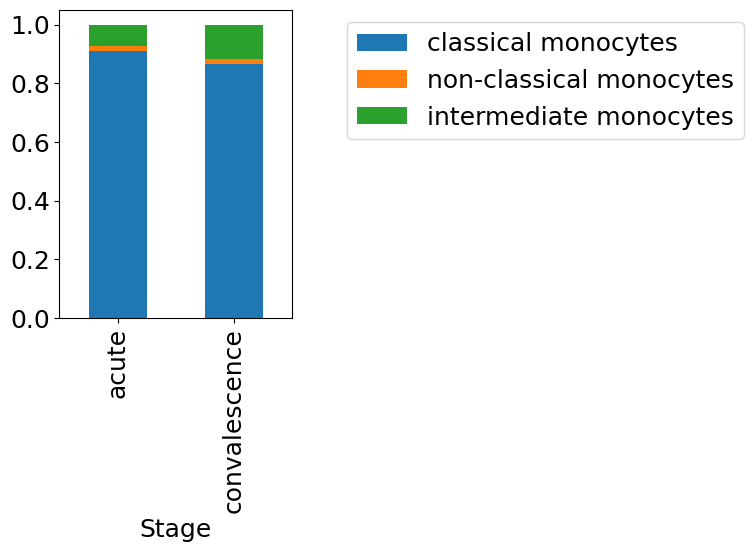

In [46]:
tmp = filtered[filtered.obs['rna_ct_2_2'] == 'Monocytes'].copy()
tmp = pd.crosstab(tmp.obs['Stage'], tmp.obs['rna_ct_3'],normalize='index')
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(3, 1.0), loc='upper right')


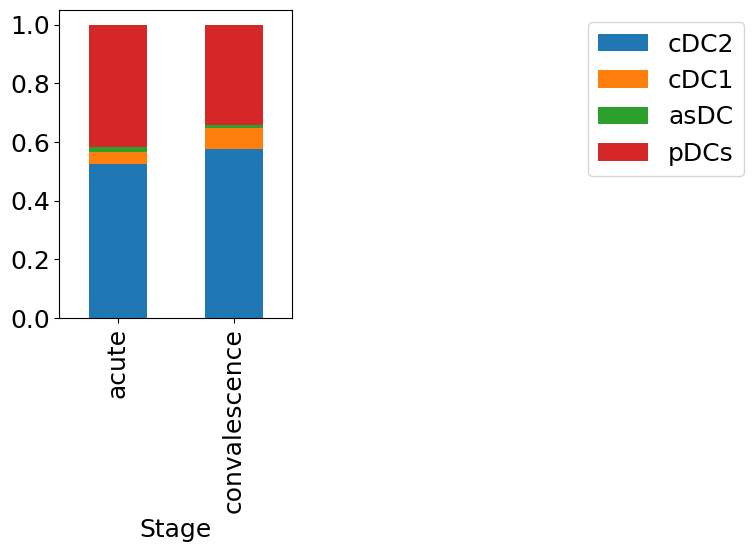

In [47]:
tmp = filtered[filtered.obs['rna_ct_2_2'].isin(['cDCs', 'pDCs'])].copy()
tmp = pd.crosstab(tmp.obs['Stage'], tmp.obs['rna_ct_3'],normalize='index')
tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(3, 1.0), loc='upper right')
